<a href="https://colab.research.google.com/github/chemvatho/chemvatho/blob/main/scipy_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, find_peaks, butter, filtfilt
import matplotlib.pyplot as plt

# Load the audio file
sample_rate, audio = wavfile.read('/content/NSNW-1-01.wav')

# Normalize audio signal (if it's in integer format)
if audio.dtype != np.float32:
    audio = audio / np.max(np.abs(audio))


<ipython-input-3-a264f2f0589a>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read('/content/NSNW-1-01.wav')


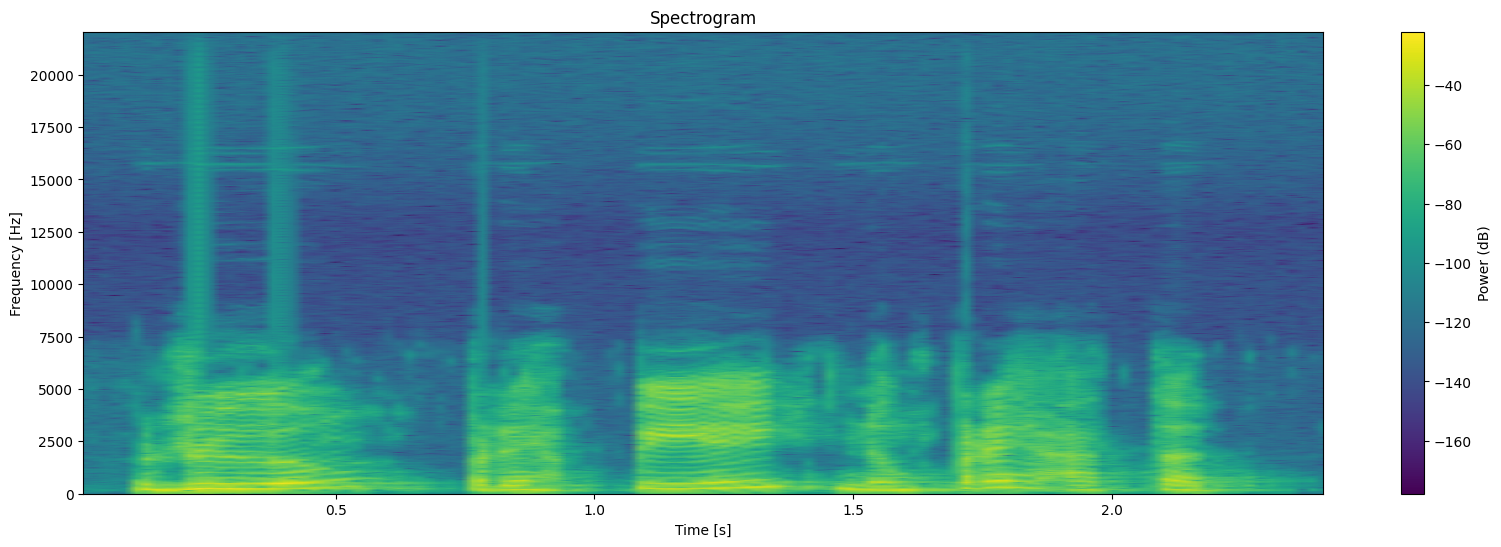

In [ ]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(audio, fs=sample_rate, nperseg=1024)

# Plot the spectrogram
plt.figure(figsize=(20, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power (dB)')
plt.show()


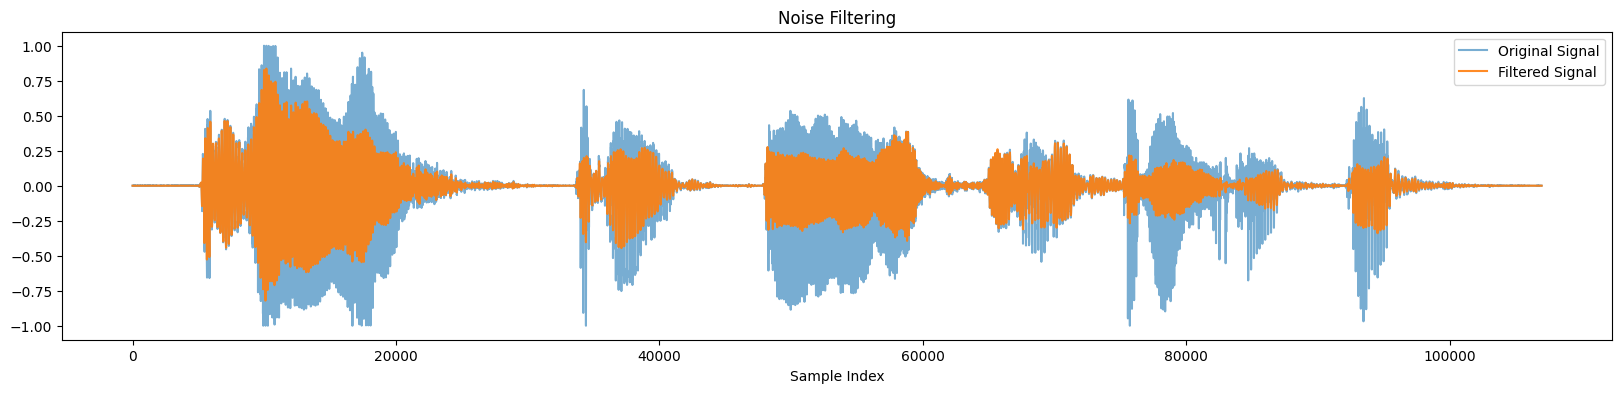

In [ ]:
# Design a low-pass filter
def lowpass_filter(signal, cutoff_freq, sample_rate):
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Apply the filter
filtered_audio = lowpass_filter(audio, cutoff_freq=500, sample_rate=sample_rate)

# Plot original and filtered signals
plt.figure(figsize=(20, 4))
plt.plot(audio, label='Original Signal', alpha=0.6)
plt.plot(filtered_audio, label='Filtered Signal', alpha=0.9)
plt.title('Noise Filtering')
plt.xlabel('Sample Index')
plt.legend()
plt.show()


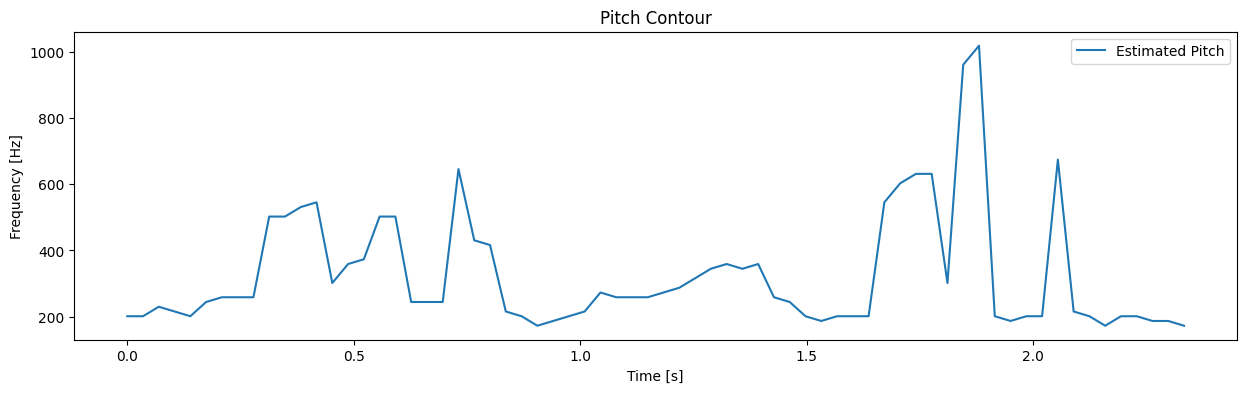

In [ ]:
def estimate_pitch(audio, sample_rate, frame_size=1024*3, hop_size=512*3):
    pitches = []
    times = []
    for i in range(0, len(audio) - frame_size, hop_size):
        frame = audio[i:i+frame_size]
        # Compute the magnitude spectrum
        spectrum = np.abs(np.fft.rfft(frame))
        freqs = np.fft.rfftfreq(len(frame), d=1/sample_rate)

        # Find the peak frequency
        peak_idx = np.argmax(spectrum)
        pitch = freqs[peak_idx]
        pitches.append(pitch)
        times.append(i / sample_rate)

    return times, pitches

# Estimate pitch
times, pitches = estimate_pitch(audio, sample_rate)

# Plot pitch over time
plt.figure(figsize=(15, 4))
plt.plot(times, pitches, label='Estimated Pitch')
plt.title('Pitch Contour')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.legend()
plt.show()


Loading and analyzing audio file...
Sample rate: 22050 Hz
Duration: 2.43 seconds


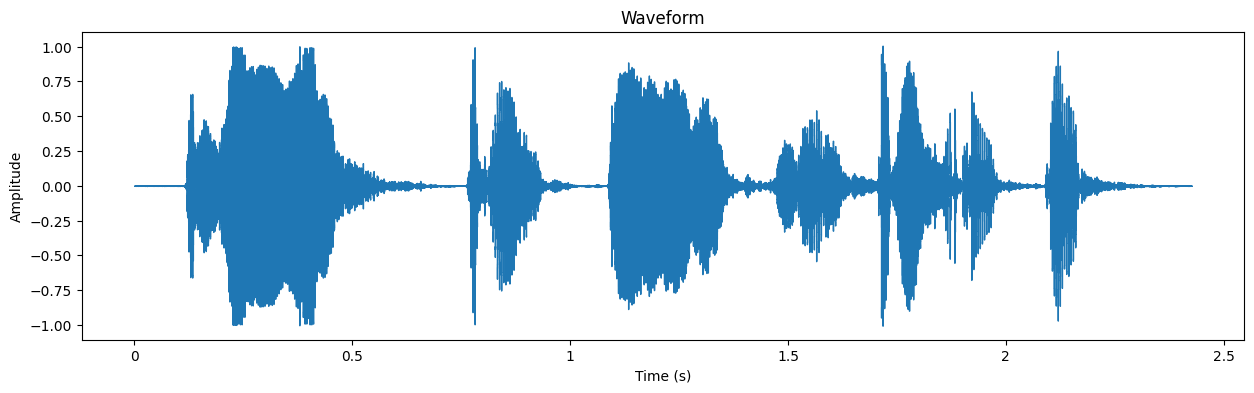


Analyzing frequency content...


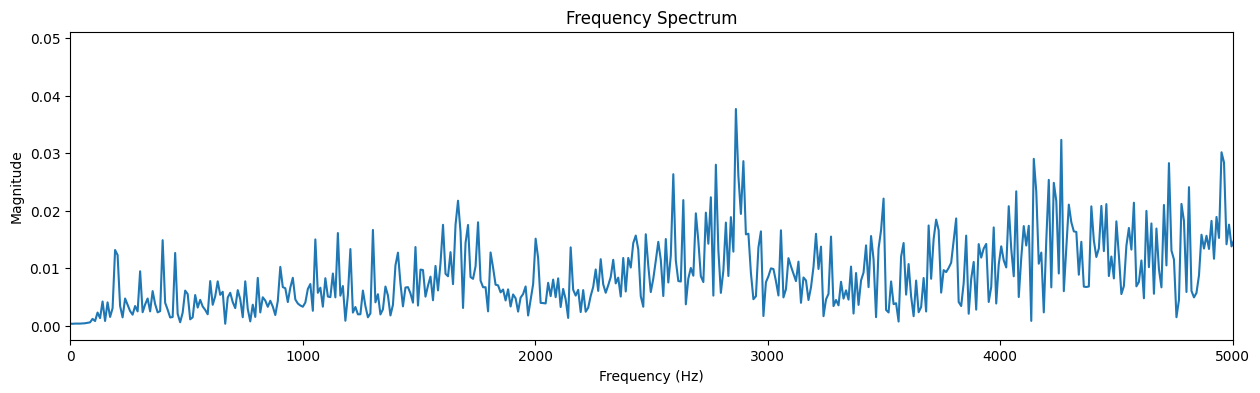


Detecting pitch...
Estimated fundamental frequency: 469.1 Hz

Computing spectrogram...


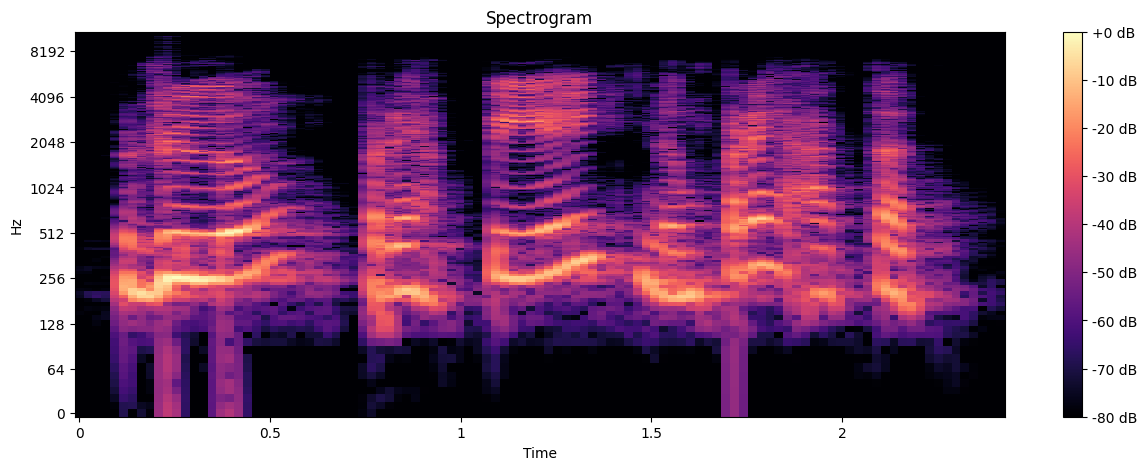


Detecting formants over time...


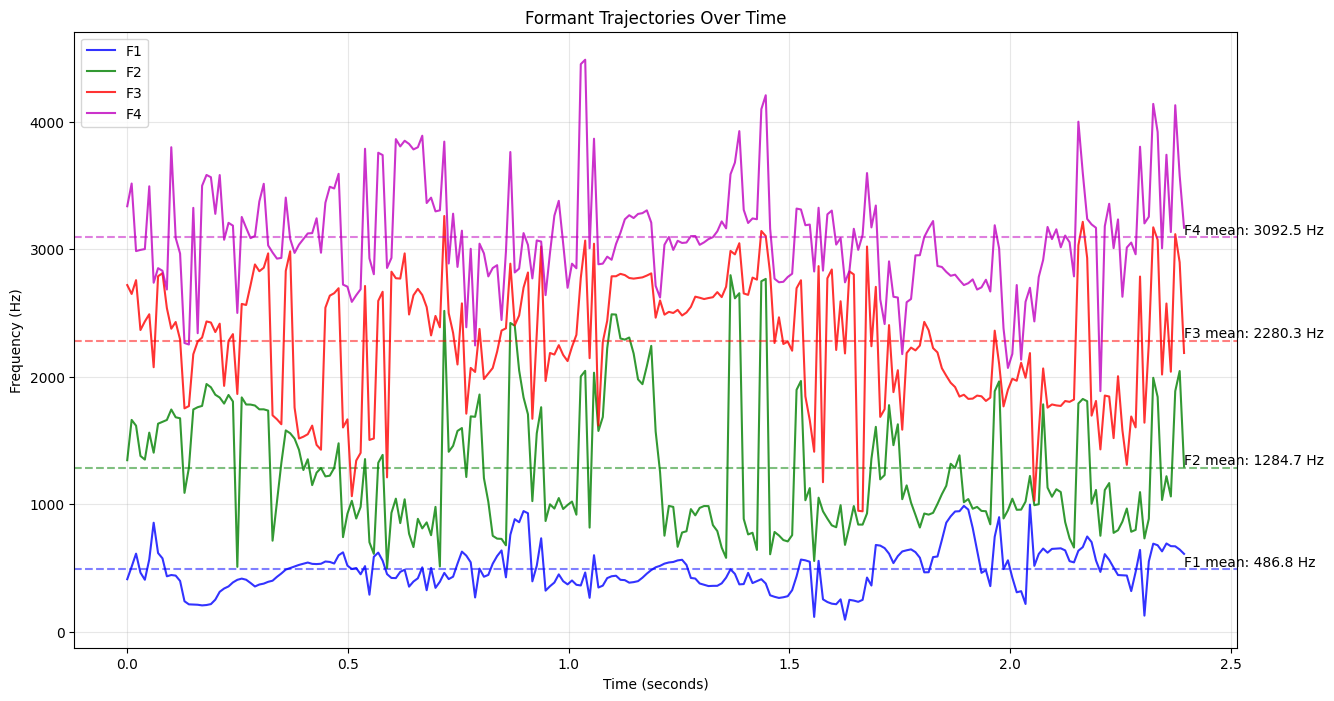


Mean formant frequencies:
F1: 486.8 Hz
F2: 1284.7 Hz
F3: 2280.3 Hz
F4: 3092.5 Hz

Analyzing audio statistics...

Audio Statistics:
Mean amplitude: 0.0000
Standard deviation: 0.1912
Skewness: -0.5436
Kurtosis: 4.8828


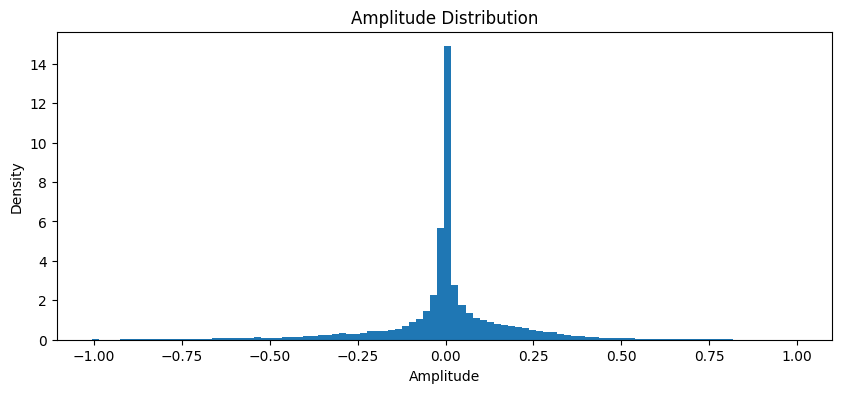

In [ ]:
# First, install required packages if not already installed
#!pip install librosa scipy matplotlib numpy

import librosa
import librosa.display
import scipy.signal as signal
from scipy.signal.windows import hamming
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Load the audio file
def load_and_analyze_audio(file_path='/content/NSNW-1-01.wav'):
    # Load the audio file
    y, sr = librosa.load(file_path)

    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {len(y)/sr:.2f} seconds")

    # Display waveform
    plt.figure(figsize=(15, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    return y, sr

# Analyze frequency content using scipy
def analyze_frequency_content(y, sr):
    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    y_emphasized = signal.lfilter([1, -pre_emphasis], [1], y)

    # Compute FFT
    n_fft = 2048
    frequencies = np.fft.fftfreq(n_fft, 1/sr)
    spectrum = np.fft.fft(y_emphasized[:n_fft])
    magnitude = np.abs(spectrum)

    # Plot spectrum
    plt.figure(figsize=(15, 4))
    plt.plot(frequencies[:n_fft//2], magnitude[:n_fft//2])
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 5000)  # Focus on speech-relevant frequencies
    plt.show()

    return frequencies, magnitude

# Detect pitch using autocorrelation
def detect_pitch(y, sr):
    # Compute autocorrelation
    correlation = signal.correlate(y, y, mode='full')
    correlation = correlation[len(correlation)//2:]

    # Find peaks in autocorrelation
    peaks = signal.find_peaks(correlation, distance=sr//500)[0]
    if len(peaks) > 1:
        fundamental_period = peaks[1] - peaks[0]
        fundamental_freq = sr / fundamental_period
        print(f"Estimated fundamental frequency: {fundamental_freq:.1f} Hz")

    return correlation

# Compute and display spectrogram
def compute_spectrogram(y, sr):
    # Compute spectrogram
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(15, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    return S_db

# Detect formants with time series
def detect_formants_over_time(y, sr):
    # Pre-emphasis
    y_preemph = signal.lfilter([1, -0.97], [1], y)

    # Frame parameters
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length = int(0.01 * sr)     # 10ms hop

    # Calculate order for LPC
    n_lpc = 2 + sr // 1000  # Rule of thumb: 2 + fs/1000

    # Initialize lists to store formants and timestamps
    formants_time_series = []
    timestamps = []

    # Process frames
    for i in range(0, len(y_preemph) - frame_length, hop_length):
        frame = y_preemph[i:i + frame_length]

        # Apply window
        frame = frame * hamming(len(frame))

        # Compute LPC coefficients
        a = librosa.lpc(frame, order=n_lpc)

        # Find roots of LPC polynomial
        roots = np.roots(np.concatenate(([1], a[1:])))
        roots = roots[np.imag(roots) >= 0]

        # Convert roots to frequencies
        angles = np.angle(roots)
        frequencies = angles * (sr / (2 * np.pi))

        # Filter and sort frequencies
        formants = sorted([f for f in frequencies if 50 < f < 5000])

        if len(formants) >= 4:  # Only keep frames with at least 4 formants
            formants_time_series.append(formants[:4])  # Keep first 4 formants
            timestamps.append(i / sr)  # Convert frame index to time

    # Convert to numpy arrays for easier manipulation
    formants_array = np.array(formants_time_series)
    timestamps = np.array(timestamps)

    # Plot formant trajectories
    plt.figure(figsize=(15, 8))
    formant_names = ['F1', 'F2', 'F3', 'F4']
    colors = ['b', 'g', 'r', 'm']

    for i in range(4):
        plt.plot(timestamps, formants_array[:, i], color=colors[i],
                label=f'{formant_names[i]}', alpha=0.8)

        # Calculate and plot mean frequency for each formant
        mean_freq = np.mean(formants_array[:, i])
        plt.axhline(y=mean_freq, color=colors[i], linestyle='--', alpha=0.5)
        plt.text(timestamps[-1], mean_freq, f'{formant_names[i]} mean: {mean_freq:.1f} Hz',
                verticalalignment='bottom')

    plt.title('Formant Trajectories Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print average formant values
    print("\nMean formant frequencies:")
    for i in range(4):
        print(f"{formant_names[i]}: {np.mean(formants_array[:, i]):.1f} Hz")

# Statistical analysis of audio features
def analyze_audio_statistics(y):
    print("\nAudio Statistics:")
    print(f"Mean amplitude: {np.mean(y):.4f}")
    print(f"Standard deviation: {np.std(y):.4f}")
    print(f"Skewness: {stats.skew(y):.4f}")
    print(f"Kurtosis: {stats.kurtosis(y):.4f}")

    # Plot amplitude distribution
    plt.figure(figsize=(10, 4))
    plt.hist(y, bins=100, density=True)
    plt.title('Amplitude Distribution')
    plt.xlabel('Amplitude')
    plt.ylabel('Density')
    plt.show()

# Main analysis pipeline
def main():
    print("Loading and analyzing audio file...")
    y, sr = load_and_analyze_audio()

    print("\nAnalyzing frequency content...")
    frequencies, magnitude = analyze_frequency_content(y, sr)

    print("\nDetecting pitch...")
    correlation = detect_pitch(y, sr)

    print("\nComputing spectrogram...")
    S_db = compute_spectrogram(y, sr)

    print("\nDetecting formants over time...")
    formants = detect_formants_over_time(y, sr)

    print("\nAnalyzing audio statistics...")
    analyze_audio_statistics(y)

    # Play the audio
    return Audio(y, rate=sr)

if __name__ == "__main__":
    main()

Loading and analyzing audio file...
Sample rate: 22050 Hz
Duration: 2.43 seconds


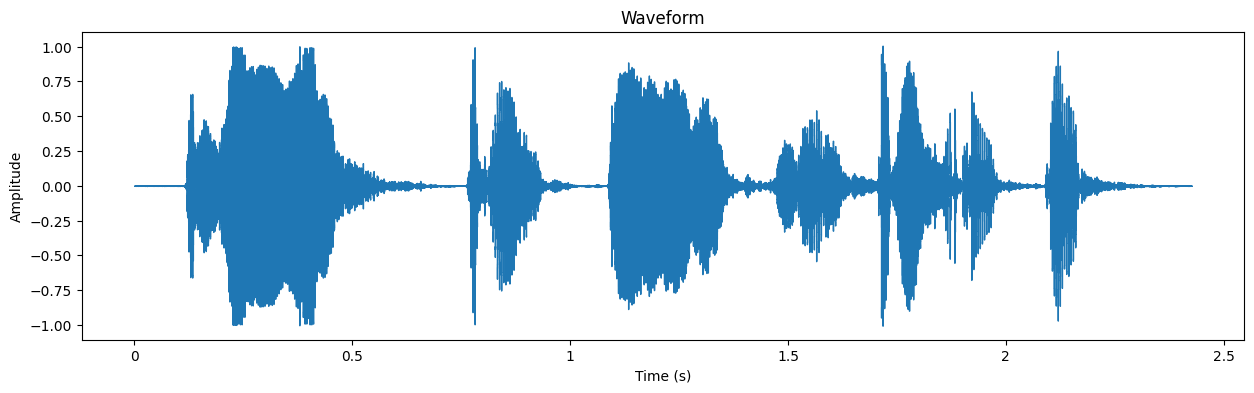


Analyzing frequency content...


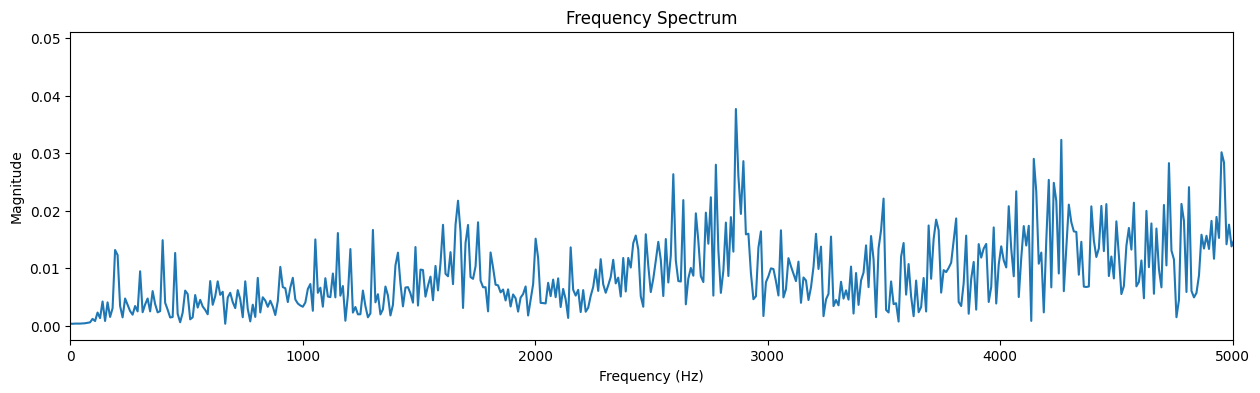


Detecting pitch...
Estimated fundamental frequency: 469.1 Hz

Computing spectrogram...


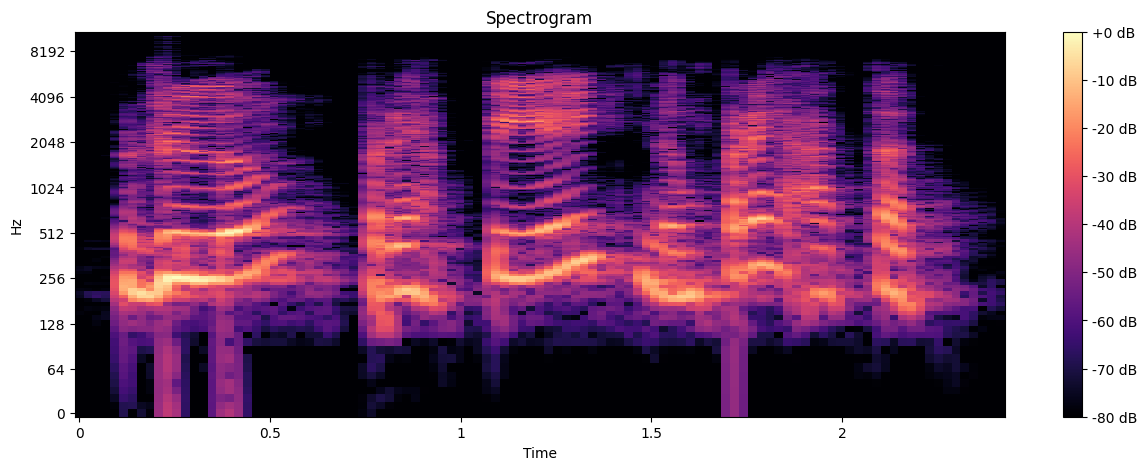


Detecting formants over time...


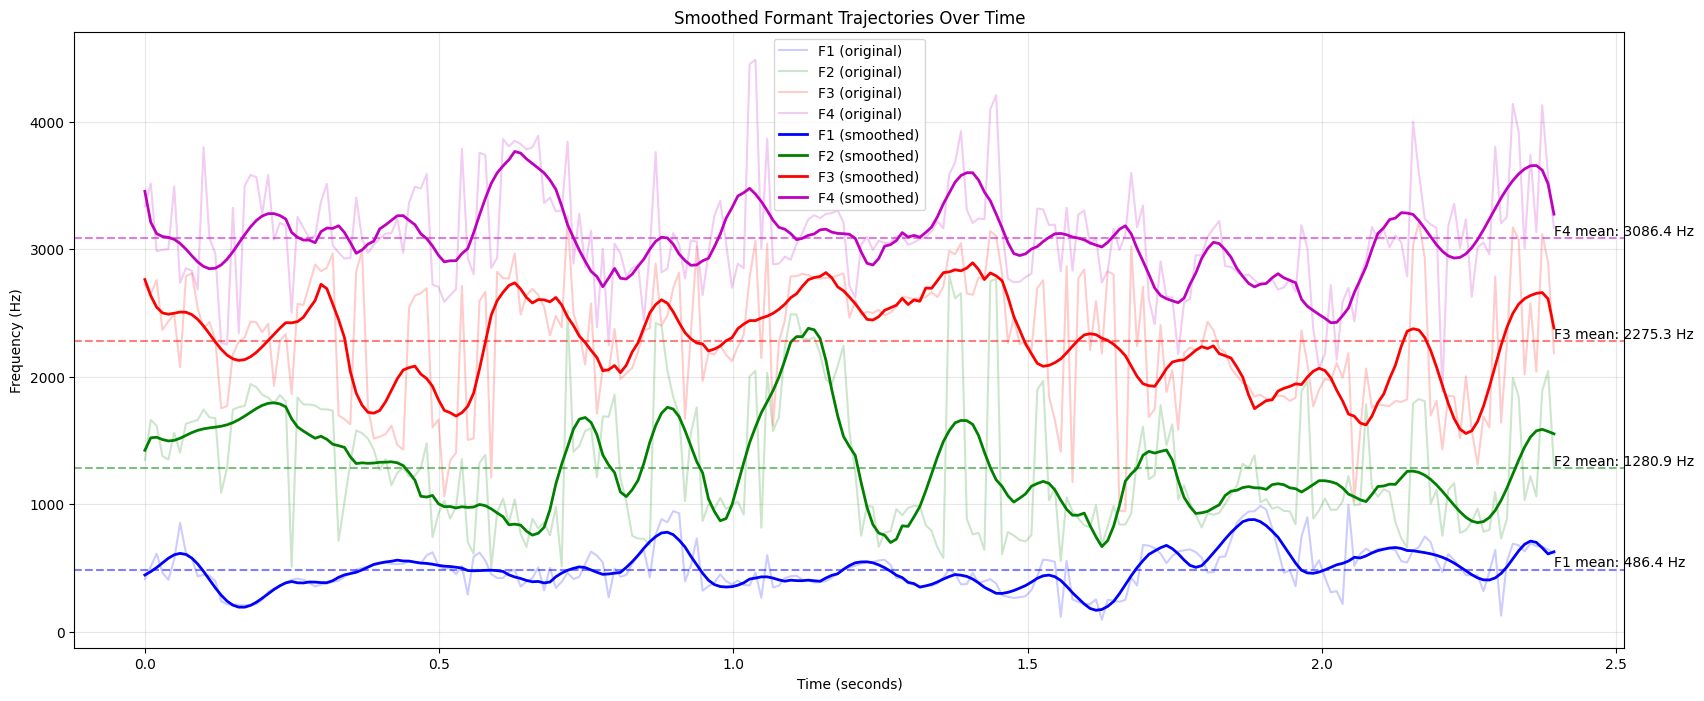


Mean formant frequencies (smoothed):
F1: 486.4 Hz
F2: 1280.9 Hz
F3: 2275.3 Hz
F4: 3086.4 Hz

Analyzing audio statistics...

Audio Statistics:
Mean amplitude: 0.0000
Standard deviation: 0.1912
Skewness: -0.5436
Kurtosis: 4.8828


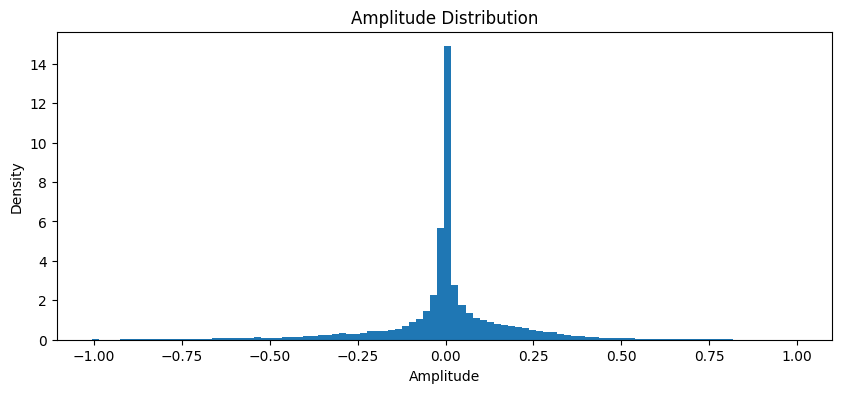

In [ ]:
# First, install required packages if not already installed
#!pip install librosa scipy matplotlib numpy

import librosa
import librosa.display
import scipy.signal as signal
from scipy.signal.windows import hamming
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Load the audio file
def load_and_analyze_audio(file_path='/content/NSNW-1-01.wav'):
    # Load the audio file
    y, sr = librosa.load(file_path)

    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {len(y)/sr:.2f} seconds")

    # Display waveform
    plt.figure(figsize=(15, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    return y, sr

# Analyze frequency content using scipy
def analyze_frequency_content(y, sr):
    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    y_emphasized = signal.lfilter([1, -pre_emphasis], [1], y)

    # Compute FFT
    n_fft = 2048
    frequencies = np.fft.fftfreq(n_fft, 1/sr)
    spectrum = np.fft.fft(y_emphasized[:n_fft])
    magnitude = np.abs(spectrum)

    # Plot spectrum
    plt.figure(figsize=(15, 4))
    plt.plot(frequencies[:n_fft//2], magnitude[:n_fft//2])
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 5000)  # Focus on speech-relevant frequencies
    plt.show()

    return frequencies, magnitude

# Detect pitch using autocorrelation
def detect_pitch(y, sr):
    # Compute autocorrelation
    correlation = signal.correlate(y, y, mode='full')
    correlation = correlation[len(correlation)//2:]

    # Find peaks in autocorrelation
    peaks = signal.find_peaks(correlation, distance=sr//500)[0]
    if len(peaks) > 1:
        fundamental_period = peaks[1] - peaks[0]
        fundamental_freq = sr / fundamental_period
        print(f"Estimated fundamental frequency: {fundamental_freq:.1f} Hz")

    return correlation

# Compute and display spectrogram
def compute_spectrogram(y, sr):
    # Compute spectrogram
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(15, 5))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

    return S_db

# Detect formants with time series and smoothing
def detect_formants_over_time(y, sr):
    # Pre-emphasis
    y_preemph = signal.lfilter([1, -0.97], [1], y)

    # Frame parameters
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length = int(0.01 * sr)     # 10ms hop

    # Calculate order for LPC
    n_lpc = 2 + sr // 1000  # Rule of thumb: 2 + fs/1000

    # Initialize lists to store formants and timestamps
    formants_time_series = []
    timestamps = []

    # Process frames
    for i in range(0, len(y_preemph) - frame_length, hop_length):
        frame = y_preemph[i:i + frame_length]

        # Apply window
        frame = frame * hamming(len(frame))

        # Compute LPC coefficients
        a = librosa.lpc(frame, order=n_lpc)

        # Find roots of LPC polynomial
        roots = np.roots(np.concatenate(([1], a[1:])))
        roots = roots[np.imag(roots) >= 0]

        # Convert roots to frequencies
        angles = np.angle(roots)
        frequencies = angles * (sr / (2 * np.pi))

        # Filter and sort frequencies
        formants = sorted([f for f in frequencies if 50 < f < 5000])

        if len(formants) >= 4:  # Only keep frames with at least 4 formants
            formants_time_series.append(formants[:4])  # Keep first 4 formants
            timestamps.append(i / sr)  # Convert frame index to time

    # Convert to numpy arrays for easier manipulation
    formants_array = np.array(formants_time_series)
    timestamps = np.array(timestamps)

    # Apply Savitzky-Golay smoothing to each formant trajectory
    window_length = 50  # Must be odd number
    poly_order = 10
    smoothed_formants = np.zeros_like(formants_array)

    for i in range(4):
        smoothed_formants[:, i] = signal.savgol_filter(
            formants_array[:, i],
            window_length=window_length,
            polyorder=poly_order
        )

    # Plot both original and smoothed formant trajectories
    plt.figure(figsize=(20, 8))
    formant_names = ['F1', 'F2', 'F3', 'F4']
    colors = ['b', 'g', 'r', 'm']

    # Plot original trajectories with low opacity
    for i in range(4):
        plt.plot(timestamps, formants_array[:, i], color=colors[i],
                alpha=0.2, label=f'{formant_names[i]} (original)')

    # Plot smoothed trajectories
    for i in range(4):
        plt.plot(timestamps, smoothed_formants[:, i], color=colors[i],
                label=f'{formant_names[i]} (smoothed)', linewidth=2)

        # Calculate and plot mean frequency for each formant
        mean_freq = np.mean(smoothed_formants[:, i])
        plt.axhline(y=mean_freq, color=colors[i], linestyle='--', alpha=0.5)
        plt.text(timestamps[-1], mean_freq, f'{formant_names[i]} mean: {mean_freq:.1f} Hz',
                verticalalignment='bottom')

    plt.title('Smoothed Formant Trajectories Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print average formant values from smoothed data
    print("\nMean formant frequencies (smoothed):")
    for i in range(4):
        print(f"{formant_names[i]}: {np.mean(smoothed_formants[:, i]):.1f} Hz")

# Statistical analysis of audio features
def analyze_audio_statistics(y):
    print("\nAudio Statistics:")
    print(f"Mean amplitude: {np.mean(y):.4f}")
    print(f"Standard deviation: {np.std(y):.4f}")
    print(f"Skewness: {stats.skew(y):.4f}")
    print(f"Kurtosis: {stats.kurtosis(y):.4f}")

    # Plot amplitude distribution
    plt.figure(figsize=(10, 4))
    plt.hist(y, bins=100, density=True)
    plt.title('Amplitude Distribution')
    plt.xlabel('Amplitude')
    plt.ylabel('Density')
    plt.show()

# Main analysis pipeline
def main():
    print("Loading and analyzing audio file...")
    y, sr = load_and_analyze_audio()

    print("\nAnalyzing frequency content...")
    frequencies, magnitude = analyze_frequency_content(y, sr)

    print("\nDetecting pitch...")
    correlation = detect_pitch(y, sr)

    print("\nComputing spectrogram...")
    S_db = compute_spectrogram(y, sr)

    print("\nDetecting formants over time...")
    formants = detect_formants_over_time(y, sr)

    print("\nAnalyzing audio statistics...")
    analyze_audio_statistics(y)

    # Play the audio
    return Audio(y, rate=sr)

if __name__ == "__main__":
    main()

# F0 extraction, adapt praat method

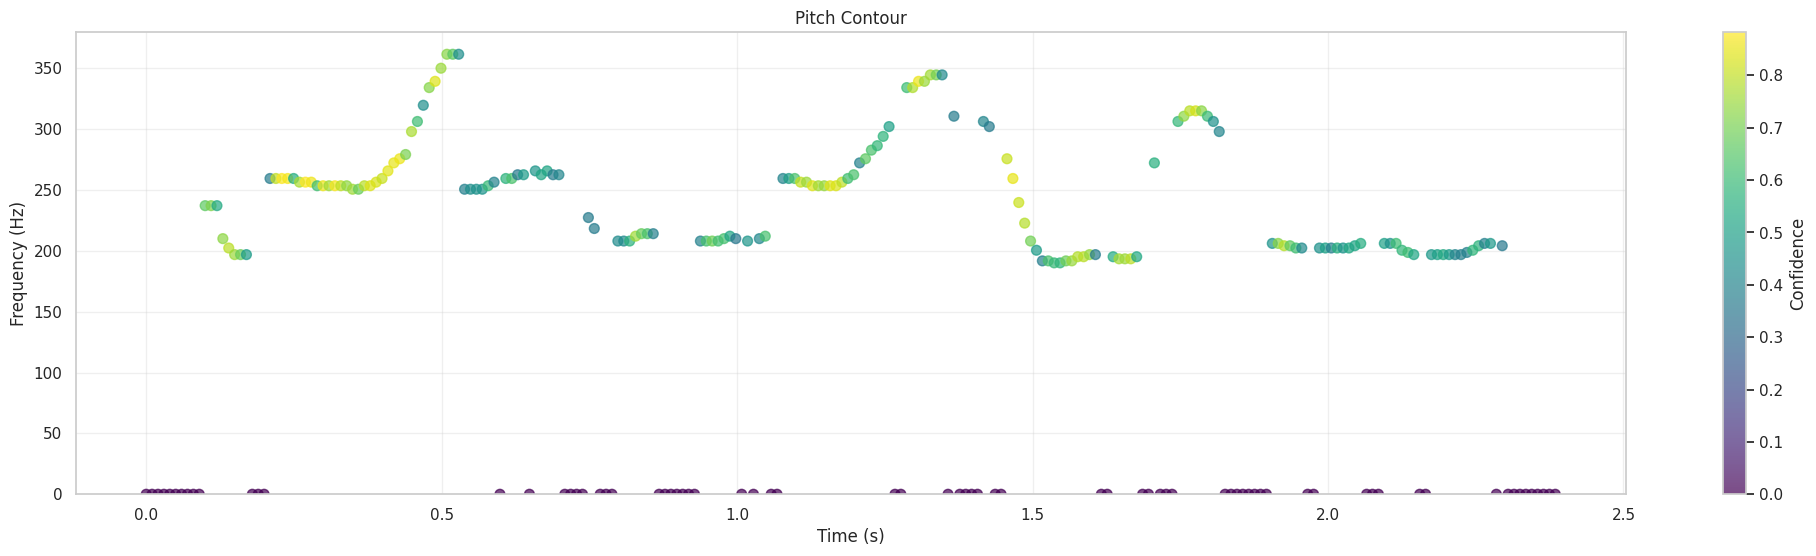


Pitch statistics for voiced regions:
Mean F0: 245.2 Hz
Median F0: 250.6 Hz
Std F0: 45.7 Hz
Min F0: 190.1 Hz
Max F0: 361.5 Hz


In [42]:
import numpy as np
from scipy import signal
from scipy.signal.windows import hann
import librosa
import matplotlib.pyplot as plt

def extract_pitch_praat_like(y, sr, f0_min=75, f0_max=400, hop_length=None, frame_length=None):
    """
    Extract pitch using a method similar to Praat's autocorrelation method.

    Parameters:
    -----------
    y : array_like
        Audio signal
    sr : int
        Sampling rate
    f0_min : float
        Minimum pitch frequency in Hz
    f0_max : float
        Maximum pitch frequency in Hz
    hop_length : int or None
        Number of samples between successive frames
    frame_length : int or None
        Length of each frame in samples

    Returns:
    --------
    times : ndarray
        Time points in seconds
    pitches : ndarray
        Pitch values in Hz
    confidence : ndarray
        Confidence values for pitch estimates
    """

    # Set default frame and hop lengths
    if frame_length is None:
        frame_length = int(0.035 * sr)  # 25ms frames
    if hop_length is None:
        hop_length = int(0.010 * sr)    # 10ms hop

    # Pre-process the signal
    y = signal.lfilter([1, -0.97], [1], y)  # Pre-emphasis

    # Initialize arrays
    n_frames = 1 + (len(y) - frame_length) // hop_length
    times = np.arange(n_frames) * hop_length / sr
    pitches = np.zeros(n_frames)
    confidence = np.zeros(n_frames)

    # Maximum and minimum lags for autocorrelation (convert from frequency to samples)
    max_lag = int(sr / f0_min)
    min_lag = int(sr / f0_max)

    # Process each frame
    for i in range(n_frames):
        # Extract frame
        start = i * hop_length
        end = start + frame_length
        frame = y[start:end]

        # Apply window
        frame = frame * hann(len(frame))

        # Compute autocorrelation
        correlation = signal.correlate(frame, frame, mode='full')
        correlation = correlation[len(correlation)//2:]  # Keep only positive lags

        # Normalize correlation
        if correlation[0] != 0:
            correlation = correlation / correlation[0]

        # Find peaks in the allowed lag range
        peaks = signal.find_peaks(correlation[min_lag:max_lag])[0] + min_lag

        if len(peaks) > 0:
            # Get the highest peak
            best_peak_idx = peaks[np.argmax(correlation[peaks])]
            pitch = sr / best_peak_idx

            # Calculate confidence based on peak height
            conf = correlation[best_peak_idx]

            # Only keep pitch if confidence is high enough
            if conf > 0.35:  # Adjust threshold as needed
                pitches[i] = pitch
                confidence[i] = conf

    # Remove zero pitches
    valid_pitch = pitches > 0

    # Smooth pitch trajectory using median filter
    if np.any(valid_pitch):
        pitches[valid_pitch] = signal.medfilt(pitches[valid_pitch], 5)

    return times, pitches, confidence

def plot_pitch(times, pitches, confidence, title="Pitch Contour"):
    """
    Plot pitch contour with confidence visualization.
    """
    plt.figure(figsize=(25, 6))

    # Plot pitch
    scatter = plt.scatter(times, pitches, c=confidence, cmap='viridis',
                         alpha=0.7, s=50)
    plt.colorbar(scatter, label='Confidence')

    # Plot smoothed line through valid pitches
    valid_pitch = pitches > 0
    if np.any(valid_pitch):
        plt.plot(times[valid_pitch], pitches[valid_pitch], 'r',  linestyle="",
                alpha=0.5, linewidth=1)

    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(bottom=0)
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
def analyze_pitch(audio_file):
    # Load audio
    y, sr = librosa.load(audio_file)

    # Extract pitch
    times, pitches, confidence = extract_pitch_praat_like(y, sr)

    # Plot results
    plot_pitch(times, pitches, confidence)

    # Print statistics for voiced regions
    voiced_pitches = pitches[pitches > 0]
    if len(voiced_pitches) > 0:
        print("\nPitch statistics for voiced regions:")
        print(f"Mean F0: {np.mean(voiced_pitches):.1f} Hz")
        print(f"Median F0: {np.median(voiced_pitches):.1f} Hz")
        print(f"Std F0: {np.std(voiced_pitches):.1f} Hz")
        print(f"Min F0: {np.min(voiced_pitches):.1f} Hz")
        print(f"Max F0: {np.max(voiced_pitches):.1f} Hz")

# To use with your file:
analyze_pitch('/content/NSNW-1-01.wav')

<ipython-input-3-6bda0f96262d>:66: UserWarning: 56 degrees provided, degrees higher than about thirty cause problems with numerical instability with 'KroghInterpolator'
  f_krogh = interpolate.KroghInterpolator(x, y)


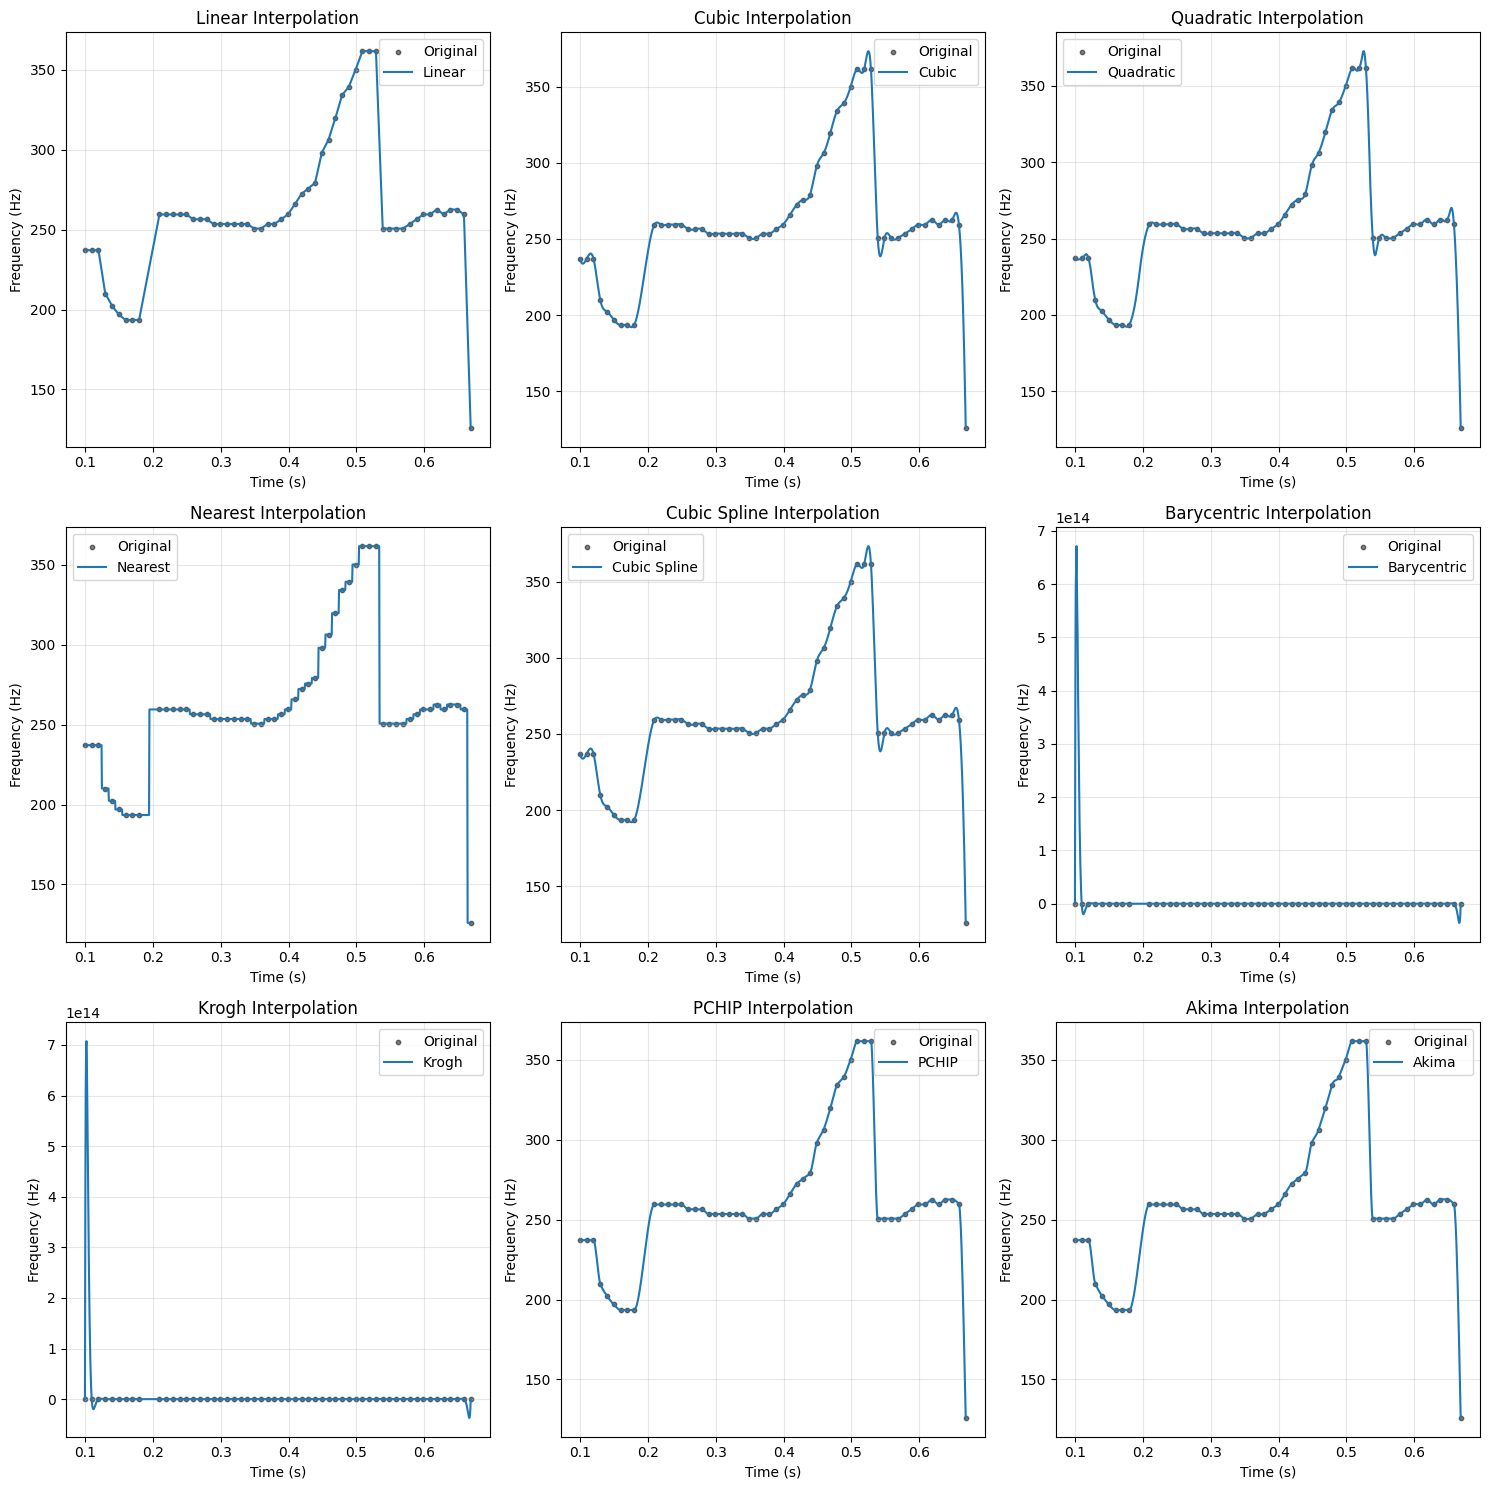


Interpolation Method Characteristics:

Linear:
Mean F0: 260.8 Hz
Std F0: 39.8 Hz
Smoothness (std of derivative): 1.4

Cubic:
Mean F0: 261.1 Hz
Std F0: 39.9 Hz
Smoothness (std of derivative): 1.5

Quadratic:
Mean F0: 261.1 Hz
Std F0: 40.0 Hz
Smoothness (std of derivative): 1.5

Nearest:
Mean F0: 260.8 Hz
Std F0: 41.4 Hz
Smoothness (std of derivative): 6.1

Cubic Spline:
Mean F0: 261.1 Hz
Std F0: 39.9 Hz
Smoothness (std of derivative): 1.5

Barycentric:
Mean F0: 5087910462718.4 Hz
Std F0: 51744626930368.6 Hz
Smoothness (std of derivative): 15137008255294.4

Krogh:
Mean F0: 5427759428766.5 Hz
Std F0: 55239608632348.5 Hz
Smoothness (std of derivative): 15910768555661.1

PCHIP:
Mean F0: 261.1 Hz
Std F0: 39.7 Hz
Smoothness (std of derivative): 1.5

Akima:
Mean F0: 261.1 Hz
Std F0: 39.7 Hz
Smoothness (std of derivative): 1.5


In [ ]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import librosa

def apply_interpolations_to_f0(times, pitches, confidence):
    """
    Apply different SciPy interpolation methods to F0 contour.
    Only interpolate voiced regions (where pitch > 0)
    """
    # Get voiced frames only
    voiced_mask = pitches > 0
    x = times[voiced_mask]
    y = pitches[voiced_mask]

    # Create a denser time axis for interpolation
    x_new = np.linspace(x.min(), x.max(), 1000)

    # Dictionary to store all interpolation results
    interpolations = {}

    # 1. Linear interpolation
    try:
        f_linear = interpolate.interp1d(x, y, kind='linear')
        interpolations['Linear'] = f_linear(x_new)
    except ValueError as e:
        print(f"Linear interpolation failed: {e}")

    # 2. Cubic interpolation
    try:
        f_cubic = interpolate.interp1d(x, y, kind='cubic')
        interpolations['Cubic'] = f_cubic(x_new)
    except ValueError as e:
        print(f"Cubic interpolation failed: {e}")

    # 3. Quadratic interpolation
    try:
        f_quadratic = interpolate.interp1d(x, y, kind='quadratic')
        interpolations['Quadratic'] = f_quadratic(x_new)
    except ValueError as e:
        print(f"Quadratic interpolation failed: {e}")

    # 4. Nearest neighbor interpolation
    try:
        f_nearest = interpolate.interp1d(x, y, kind='nearest')
        interpolations['Nearest'] = f_nearest(x_new)
    except ValueError as e:
        print(f"Nearest interpolation failed: {e}")

    # 5. Cubic spline interpolation (more natural curves)
    try:
        cs = interpolate.CubicSpline(x, y)
        interpolations['Cubic Spline'] = cs(x_new)
    except ValueError as e:
        print(f"Cubic spline interpolation failed: {e}")

    # 6. Barycentric interpolation
    try:
        f_barycentric = interpolate.BarycentricInterpolator(x, y)
        interpolations['Barycentric'] = f_barycentric(x_new)
    except ValueError as e:
        print(f"Barycentric interpolation failed: {e}")

    # 7. Krogh's interpolation (tends to be more accurate than Lagrange)
    try:
        f_krogh = interpolate.KroghInterpolator(x, y)
        interpolations['Krogh'] = f_krogh(x_new)
    except ValueError as e:
        print(f"Krogh interpolation failed: {e}")

    # 8. Piecewise Cubic Hermite Interpolating Polynomial (PCHIP)
    try:
        f_pchip = interpolate.PchipInterpolator(x, y)
        interpolations['PCHIP'] = f_pchip(x_new)
    except ValueError as e:
        print(f"PCHIP interpolation failed: {e}")

    # 9. Akima interpolation (handles outliers better)
    try:
        f_akima = interpolate.Akima1DInterpolator(x, y)
        interpolations['Akima'] = f_akima(x_new)
    except ValueError as e:
        print(f"Akima interpolation failed: {e}")

    # Plot all successful interpolations
    n_plots = len(interpolations)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    for i, (name, y_interp) in enumerate(interpolations.items()):
        ax = axes[i]
        # Plot original points
        ax.scatter(x, y, c='black', s=10, alpha=0.5, label='Original')
        # Plot interpolation
        ax.plot(x_new, y_interp, label=name)
        ax.set_title(f'{name} Interpolation')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Remove empty subplots if any
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    return x_new, interpolations

def analyze_interpolations(y, sr):
    """
    Extract pitch and apply interpolations
    """
    # First extract pitch using our previous function
    times, pitches, confidence = extract_pitch_praat_like(y, sr)

    # Apply and visualize interpolations
    x_new, interpolations = apply_interpolations_to_f0(times, pitches, confidence)

    # Compare interpolation methods quantitatively
    print("\nInterpolation Method Characteristics:")
    for name, y_interp in interpolations.items():
        print(f"\n{name}:")
        print(f"Mean F0: {np.mean(y_interp):.1f} Hz")
        print(f"Std F0: {np.std(y_interp):.1f} Hz")
        print(f"Smoothness (std of derivative): {np.std(np.diff(y_interp)):.1f}")

# To use with your file:
y, sr = librosa.load('/content/NSNW-1-01_first_word.wav')
analyze_interpolations(y, sr)

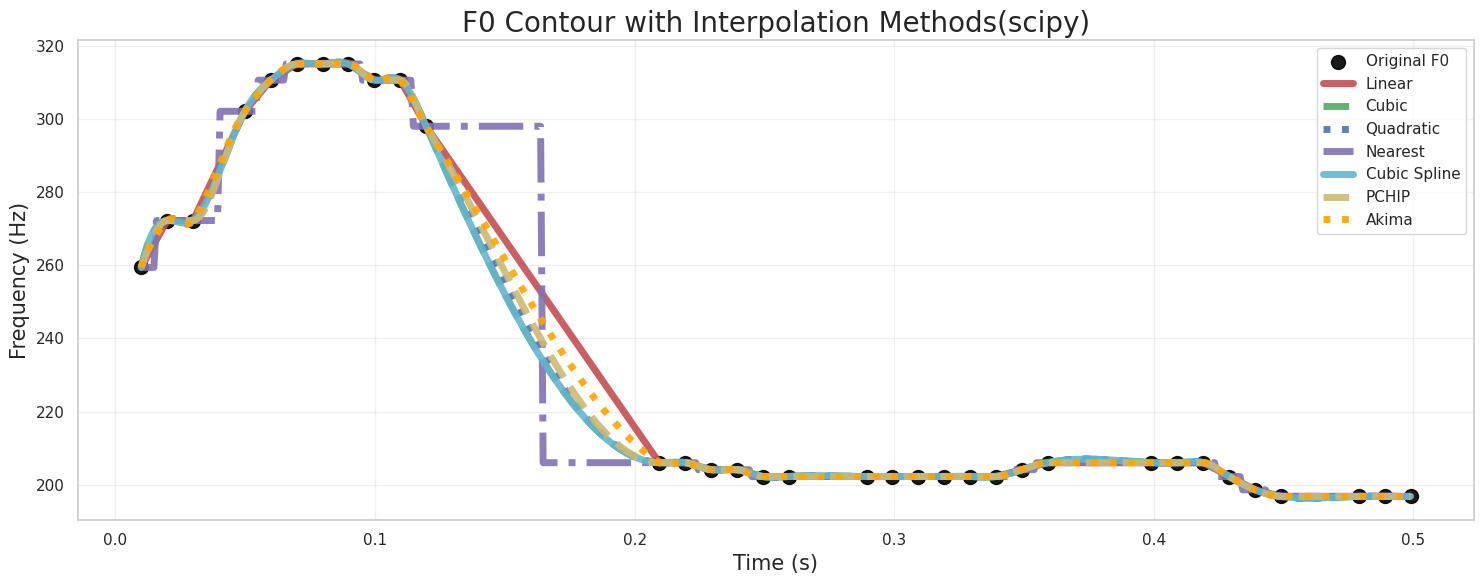


Interpolation Method Characteristics:

Linear:
Mean F0: 233.2 Hz
Std F0: 42.4 Hz
Smoothness (std of derivative): 0.6

Cubic:
Mean F0: 231.1 Hz
Std F0: 41.9 Hz
Smoothness (std of derivative): 0.6

Quadratic:
Mean F0: 231.3 Hz
Std F0: 42.0 Hz
Smoothness (std of derivative): 0.6

Nearest:
Mean F0: 233.1 Hz
Std F0: 45.4 Hz
Smoothness (std of derivative): 4.4

Cubic Spline:
Mean F0: 231.1 Hz
Std F0: 41.9 Hz
Smoothness (std of derivative): 0.6

PCHIP:
Mean F0: 231.6 Hz
Std F0: 42.2 Hz
Smoothness (std of derivative): 0.6

Akima:
Mean F0: 232.3 Hz
Std F0: 42.3 Hz
Smoothness (std of derivative): 0.6


In [44]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import librosa

def apply_interpolations_to_f0(times, pitches, confidence):
    """
    Apply different SciPy interpolation methods to F0 contour.
    Only interpolate voiced regions (where pitch > 0)
    """
    # Get voiced frames only
    voiced_mask = pitches > 0
    x = times[voiced_mask]
    y = pitches[voiced_mask]

    # Create a denser time axis for interpolation
    x_new = np.linspace(x.min(), x.max(), 500)

    # Dictionary to store all interpolation results
    interpolations = {}

    # 1. Linear interpolation
    try:
        f_linear = interpolate.interp1d(x, y, kind='linear')
        interpolations['Linear'] = f_linear(x_new)
    except ValueError as e:
        print(f"Linear interpolation failed: {e}")

    # 2. Cubic interpolation
    try:
        f_cubic = interpolate.interp1d(x, y, kind='cubic')
        interpolations['Cubic'] = f_cubic(x_new)
    except ValueError as e:
        print(f"Cubic interpolation failed: {e}")

    # 3. Quadratic interpolation
    try:
        f_quadratic = interpolate.interp1d(x, y, kind='quadratic')
        interpolations['Quadratic'] = f_quadratic(x_new)
    except ValueError as e:
        print(f"Quadratic interpolation failed: {e}")

    # 4. Nearest neighbor interpolation
    try:
        f_nearest = interpolate.interp1d(x, y, kind='nearest')
        interpolations['Nearest'] = f_nearest(x_new)
    except ValueError as e:
        print(f"Nearest interpolation failed: {e}")

    # 5. Cubic spline interpolation (more natural curves)
    try:
        cs = interpolate.CubicSpline(x, y)
        interpolations['Cubic Spline'] = cs(x_new)
    except ValueError as e:
        print(f"Cubic spline interpolation failed: {e}")

    # 6. PCHIP (Piecewise Cubic Hermite)
    try:
        f_pchip = interpolate.PchipInterpolator(x, y)
        interpolations['PCHIP'] = f_pchip(x_new)
    except ValueError as e:
        print(f"PCHIP interpolation failed: {e}")

    # 7. Akima interpolation
    try:
        f_akima = interpolate.Akima1DInterpolator(x, y)
        interpolations['Akima'] = f_akima(x_new)
    except ValueError as e:
        print(f"Akima interpolation failed: {e}")

    # Plot all interpolations on a single graph
    plt.figure(figsize=(15, 6))

    # Plot original points
    plt.scatter(x, y, c='black', s=100, alpha=0.9, label='Original F0')

    # Plot each interpolation with different colors and styles
    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange']
    styles = ['-', '--', ':', '-.', '-', '--', ':']

    for (name, y_interp), color, style in zip(interpolations.items(), colors, styles):
        plt.plot(x_new, y_interp, color=color, linestyle=style, linewidth=5, label=name, alpha=0.9)

    plt.title('F0 Contour with Interpolation Methods(scipy)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Frequency (Hz)', fontsize=15)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('interpolation_methods.png', dpi=1000, bbox_inches="tight")
    plt.show()

    return x_new, interpolations

def analyze_interpolations(y, sr):
    """
    Extract pitch and apply interpolations
    """
    # First extract pitch using our previous function
    times, pitches, confidence = extract_pitch_praat_like(y, sr)

    # Apply and visualize interpolations
    x_new, interpolations = apply_interpolations_to_f0(times, pitches, confidence)

    # Compare interpolation methods quantitatively
    print("\nInterpolation Method Characteristics:")
    for name, y_interp in interpolations.items():
        print(f"\n{name}:")
        print(f"Mean F0: {np.mean(y_interp):.1f} Hz")
        print(f"Std F0: {np.std(y_interp):.1f} Hz")
        print(f"Smoothness (std of derivative): {np.std(np.diff(y_interp)):.1f}")

# To use with your file:
y, sr = librosa.load('/content/NSNW-1-01_second-1.wav')
analyze_interpolations(y, sr)

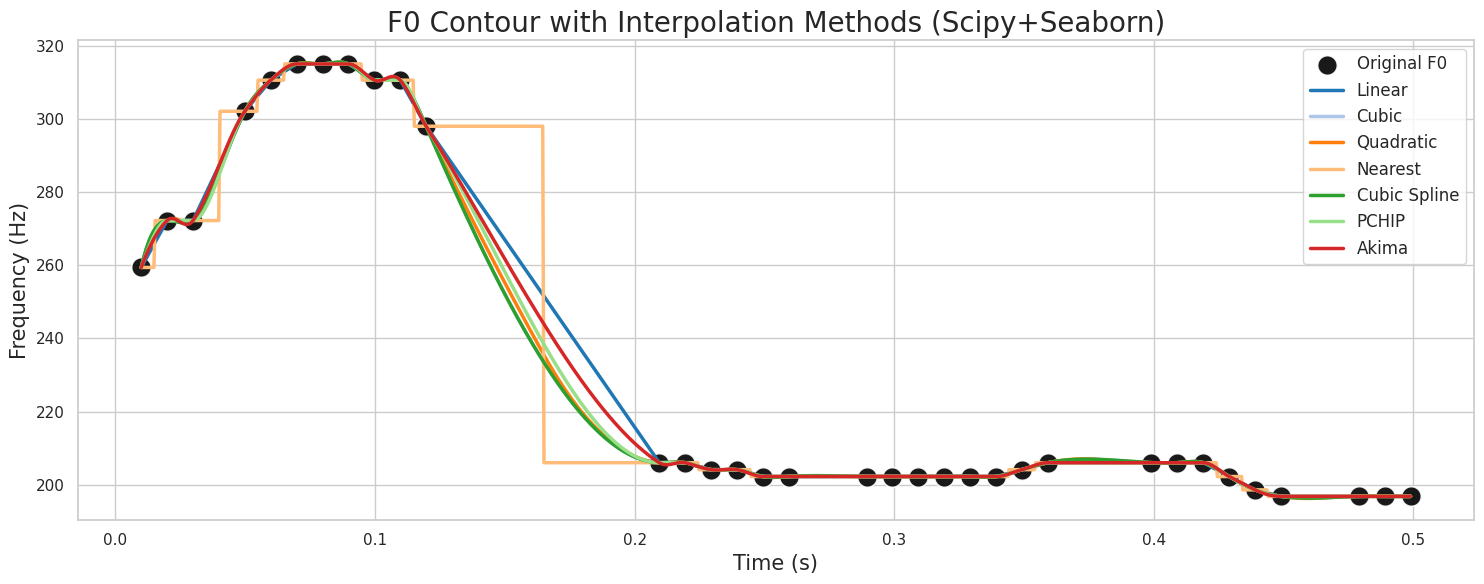


Interpolation Method Characteristics:

Linear:
Mean F0: 233.2 Hz
Std F0: 42.4 Hz
Smoothness (std of derivative): 0.3

Cubic:
Mean F0: 231.1 Hz
Std F0: 41.9 Hz
Smoothness (std of derivative): 0.3

Quadratic:
Mean F0: 231.3 Hz
Std F0: 42.1 Hz
Smoothness (std of derivative): 0.3

Nearest:
Mean F0: 233.3 Hz
Std F0: 45.5 Hz
Smoothness (std of derivative): 3.1

Cubic Spline:
Mean F0: 231.1 Hz
Std F0: 41.9 Hz
Smoothness (std of derivative): 0.3

PCHIP:
Mean F0: 231.6 Hz
Std F0: 42.2 Hz
Smoothness (std of derivative): 0.3

Akima:
Mean F0: 232.3 Hz
Std F0: 42.3 Hz
Smoothness (std of derivative): 0.3


In [43]:
import numpy as np
from scipy import interpolate
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

# Set Seaborn style
sns.set_theme(style="whitegrid")

def apply_interpolations_to_f0(times, pitches, confidence):
    """
    Apply different SciPy interpolation methods to F0 contour.
    Only interpolate voiced regions (where pitch > 0)
    """
    # Get voiced frames only
    voiced_mask = pitches > 0
    x = times[voiced_mask]
    y = pitches[voiced_mask]

    # Create a denser time axis for interpolation
    x_new = np.linspace(x.min(), x.max(), 1000)

    # Dictionary to store all interpolation results
    interpolations = {}

    # 1. Linear interpolation
    try:
        f_linear = interpolate.interp1d(x, y, kind='linear')
        interpolations['Linear'] = f_linear(x_new)
    except ValueError as e:
        print(f"Linear interpolation failed: {e}")

    # 2. Cubic interpolation
    try:
        f_cubic = interpolate.interp1d(x, y, kind='cubic')
        interpolations['Cubic'] = f_cubic(x_new)
    except ValueError as e:
        print(f"Cubic interpolation failed: {e}")

    # 3. Quadratic interpolation
    try:
        f_quadratic = interpolate.interp1d(x, y, kind='quadratic')
        interpolations['Quadratic'] = f_quadratic(x_new)
    except ValueError as e:
        print(f"Quadratic interpolation failed: {e}")

    # 4. Nearest neighbor interpolation
    try:
        f_nearest = interpolate.interp1d(x, y, kind='nearest')
        interpolations['Nearest'] = f_nearest(x_new)
    except ValueError as e:
        print(f"Nearest interpolation failed: {e}")

    # 5. Cubic spline interpolation (more natural curves)
    try:
        cs = interpolate.CubicSpline(x, y)
        interpolations['Cubic Spline'] = cs(x_new)
    except ValueError as e:
        print(f"Cubic spline interpolation failed: {e}")

    # 6. PCHIP (Piecewise Cubic Hermite)
    try:
        f_pchip = interpolate.PchipInterpolator(x, y)
        interpolations['PCHIP'] = f_pchip(x_new)
    except ValueError as e:
        print(f"PCHIP interpolation failed: {e}")

    # 7. Akima interpolation
    try:
        f_akima = interpolate.Akima1DInterpolator(x, y)
        interpolations['Akima'] = f_akima(x_new)
    except ValueError as e:
        print(f"Akima interpolation failed: {e}")

    # Plot all interpolations on a single graph
    plt.figure(figsize=(15, 6))

    # Plot original points
    sns.scatterplot(x=x, y=y, color='black', s=200, label='Original F0', alpha=0.9)

    # Plot each interpolation with different colors and styles
    palette = sns.color_palette("tab20", len(interpolations))
    for (name, y_interp), color in zip(interpolations.items(), palette):
        sns.lineplot(x=x_new, y=y_interp, label=name, color=color, linewidth=2.5, linestyle="-")

    plt.title('F0 Contour with Interpolation Methods (Scipy+Seaborn)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Frequency (Hz)', fontsize=15)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.savefig('interpolation_methods_seaborn.png', dpi=1000, bbox_inches="tight")
    plt.show()

    return x_new, interpolations

def analyze_interpolations(y, sr):
    """
    Extract pitch and apply interpolations
    """
    # First extract pitch using your previous function
    times, pitches, confidence = extract_pitch_praat_like(y, sr)

    # Apply and visualize interpolations
    x_new, interpolations = apply_interpolations_to_f0(times, pitches, confidence)

    # Compare interpolation methods quantitatively
    print("\nInterpolation Method Characteristics:")
    for name, y_interp in interpolations.items():
        print(f"\n{name}:")
        print(f"Mean F0: {np.mean(y_interp):.1f} Hz")
        print(f"Std F0: {np.std(y_interp):.1f} Hz")
        print(f"Smoothness (std of derivative): {np.std(np.diff(y_interp)):.1f}")

# To use with your file:
y, sr = librosa.load('/content/NSNW-1-01_second-1.wav')
analyze_interpolations(y, sr)
